In [2]:
import csv
import chess
import chess.pgn
import io
import os
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    r2_score,
    silhouette_score,
)
from warnings import filterwarnings
from io import StringIO

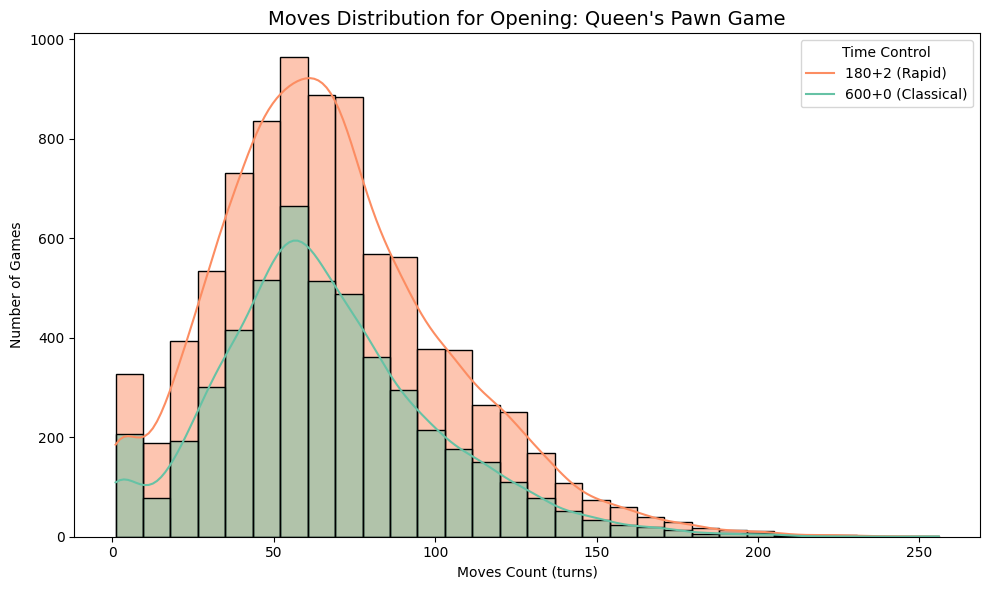

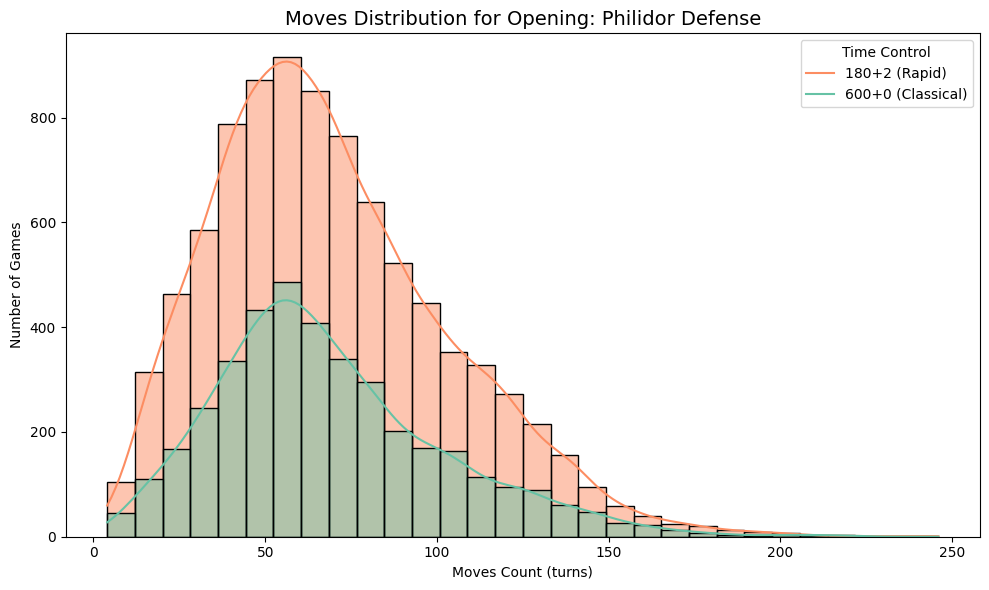

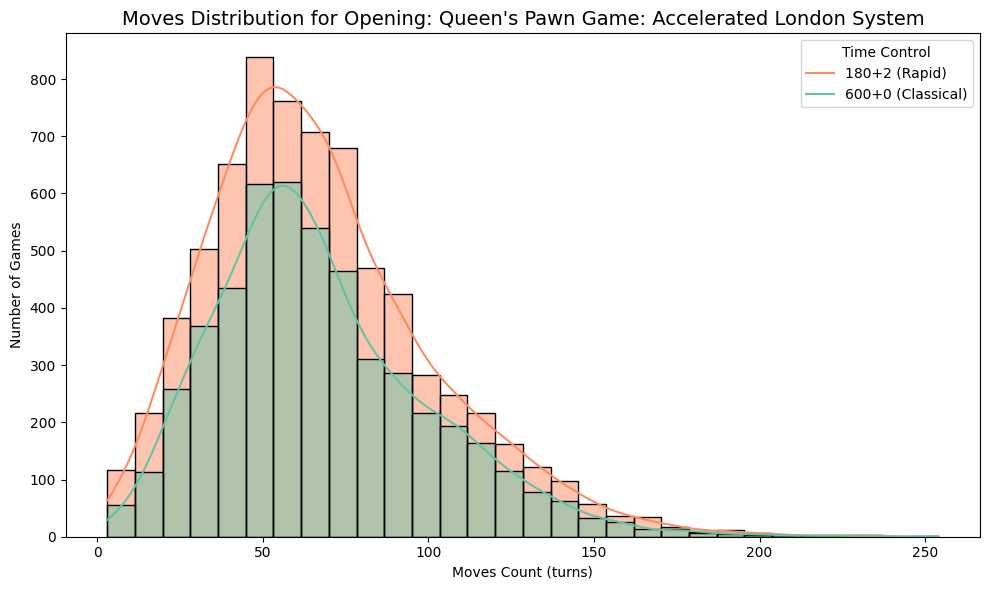

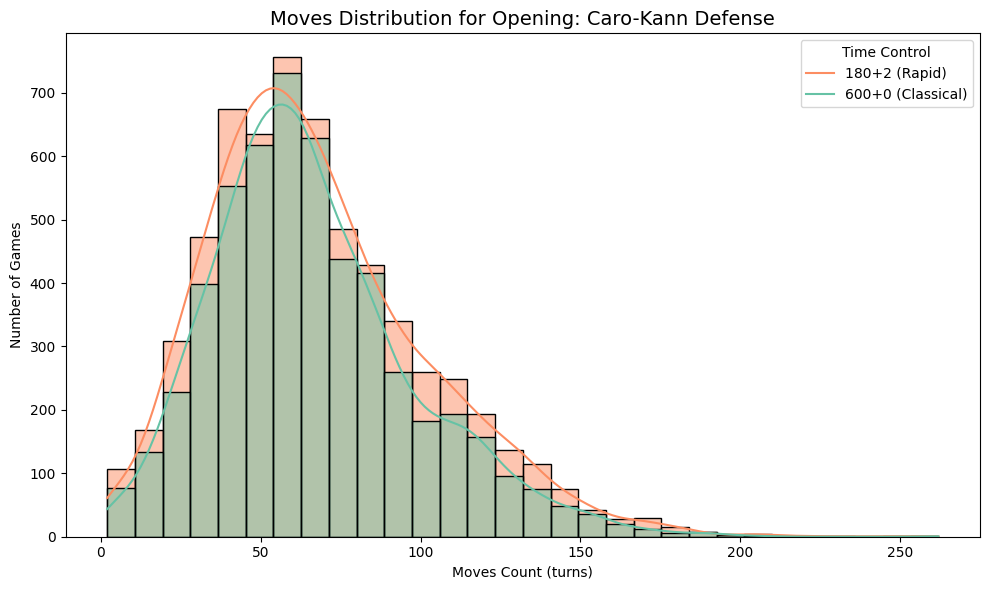

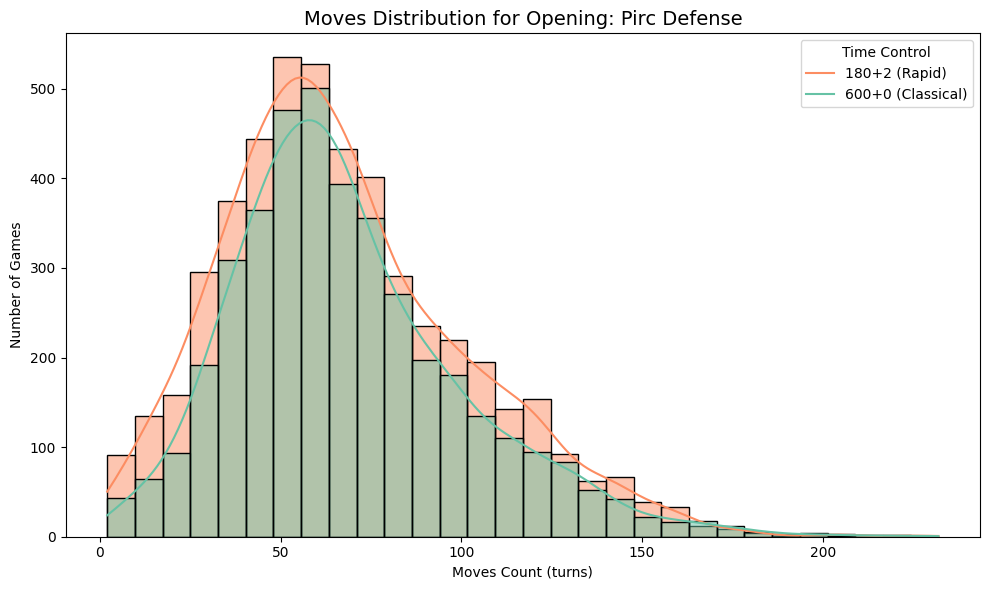

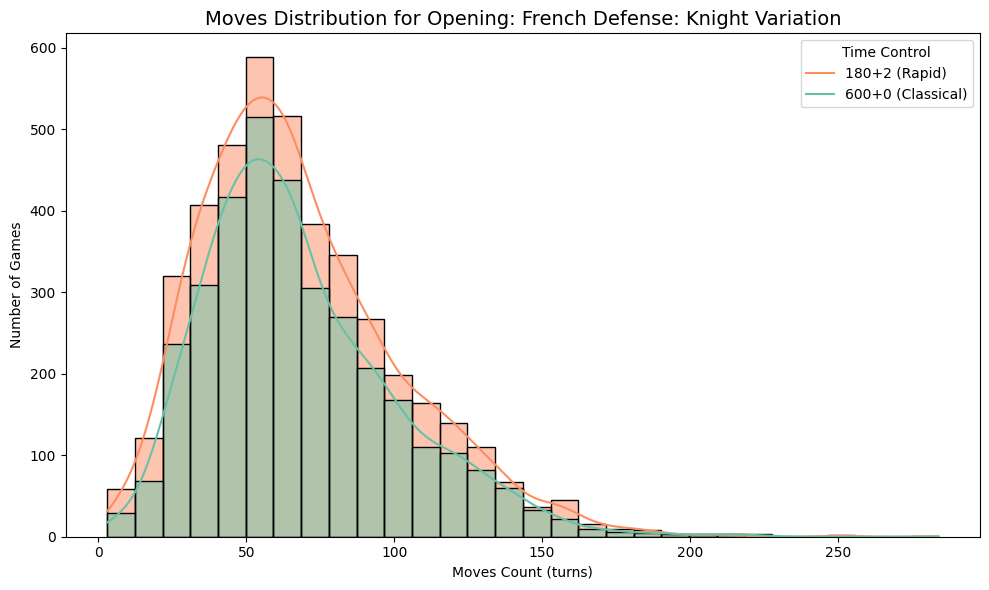

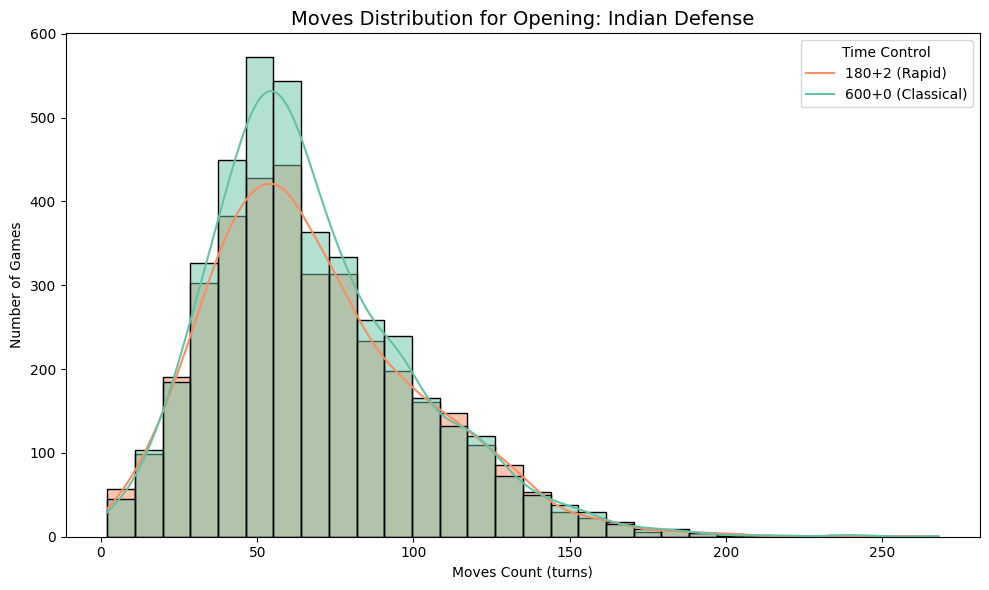

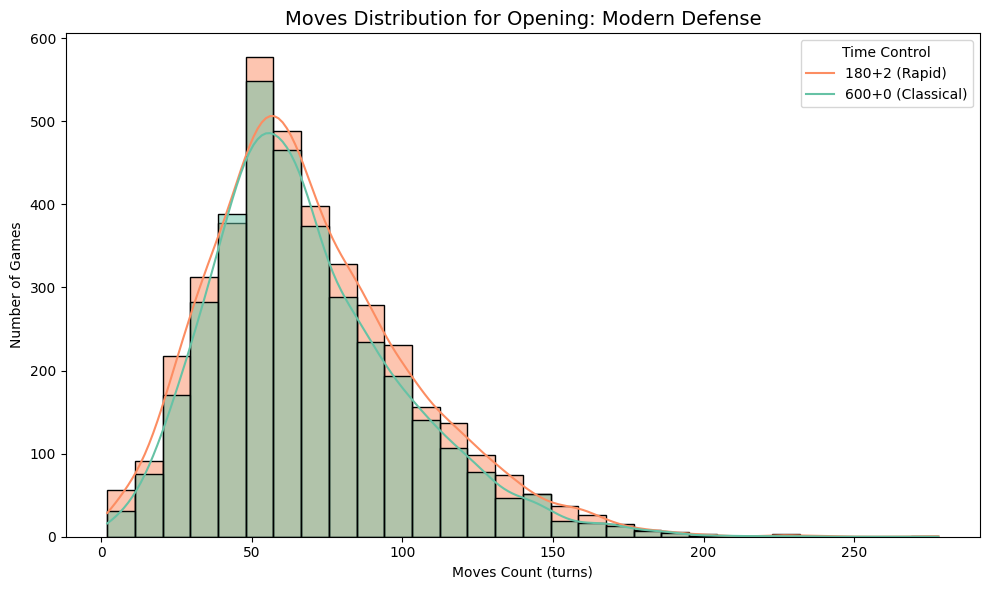

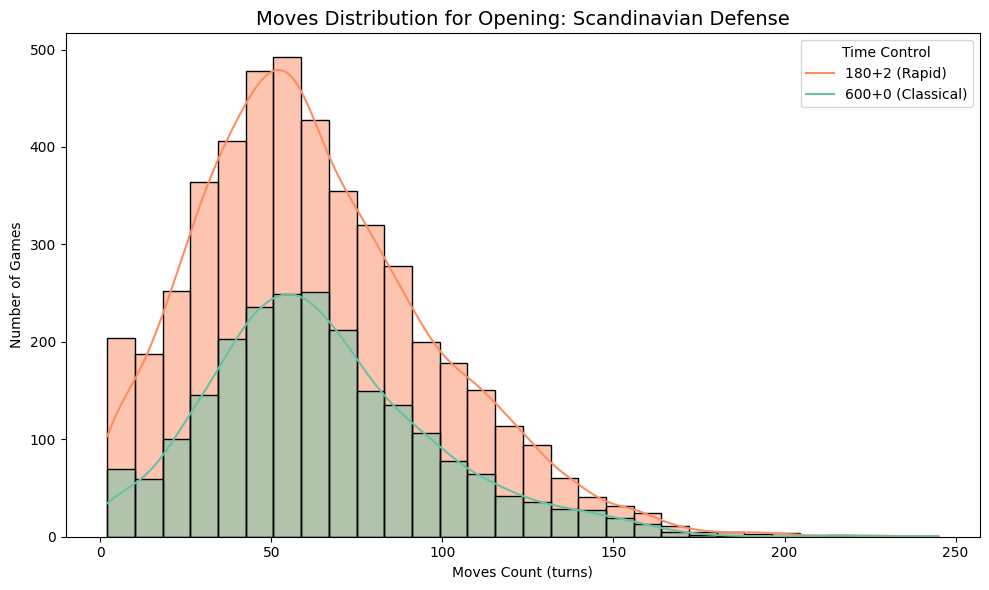

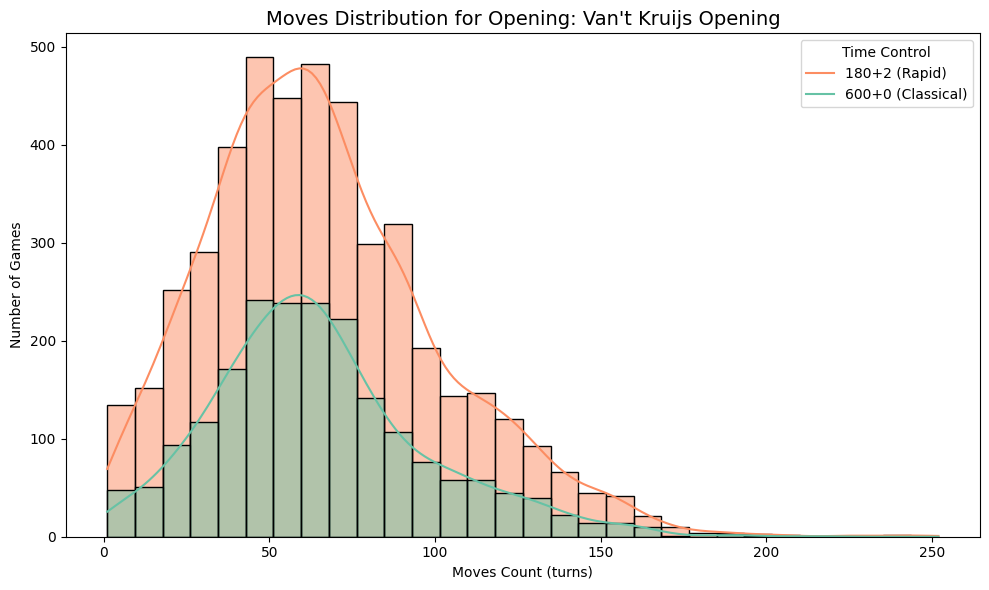

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# 轉換棋譜文字為走法數（半步數）
def count_half_moves(moves_str):
    if pd.isna(moves_str):
        return None
    cleaned = moves_str.replace('\n', ' ').replace('\r', ' ')
    tokens = cleaned.split()
    moves = [t for t in tokens if not t.endswith('.') and '...' not in t and not t.replace('.', '').isdigit()]
    return len(moves)

# 讀取 parquet 資料並處理
def load_and_process_parquet(folder_path, time_control_label):
    file_paths = glob.glob(os.path.join(folder_path, "chunk_*.parquet"))
    df_list = [pd.read_parquet(fp) for fp in file_paths]
    df = pd.concat(df_list, ignore_index=True)
    df["TimeControl"] = time_control_label
    df["MovesCount"] = df["MovesProcessed"].apply(count_half_moves)
    return df

# 載入資料（可移除 [:300] 限制以讀取所有檔案）
df_180 = load_and_process_parquet("PARQUET/180+2", "180+2")
df_600 = load_and_process_parquet("PARQUET/600+0", "600+0")

# 合併
df = pd.concat([df_180, df_600], ignore_index=True)
df = df.dropna(subset=["Opening", "MovesCount"])

# 找出前 10 名樣本數最多的開局
top_openings = (
    df.groupby("Opening")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

# 篩選前 10 開局的資料
df_top = df[df["Opening"].isin(top_openings)]

# 畫出每個開局的步數分布（分時間控制）
for opening in top_openings:
    plt.figure(figsize=(10, 6))
    plot = sns.histplot(
        data=df_top[df_top["Opening"] == opening],
        x="MovesCount",
        hue="TimeControl",
        bins=30,
        kde=True,
        palette="Set2"
    )
    plt.title(f"Moves Distribution for Opening: {opening}", fontsize=14)
    plt.xlabel("Moves Count (turns)")
    plt.ylabel("Number of Games")
    plt.legend(title="Time Control", labels=["180+2 (Rapid)", "600+0 (Classical)"])
    plt.tight_layout()
    plt.show()
